In [10]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
import math
import os
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
import shutil
try:
    shutil.rmtree("populations")
    os.mkdir("populations")
except:
    os.mkdir("populations")
# Define the airfoil function
n_ctr_pts = 10
angle_attack = 10
n_times = 120
max_iterations= 100
# Genetic Algorithm parameters
population_size = 70
max_generations = 70
mach = 0.15
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [11]:

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=xvals, y=yvals)

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [12]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.mach = mach
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(angle_attack)
    return cl, cd

In [13]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(angle_attack)
    if math.isnan(cl) or math.isnan(cd):
        return 0, -10e5
    else:
        # Return Cl and -Cd (minimize Cd -> maximize -Cd)
        return cl, -cd


In [14]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil_angle_attacks(individual, min=-20, max=20, step=1):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)

    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return a, cl, cd


In [15]:
def naca_eval(min=-20, max=20, step=1):
    xf = XFoil()
    xf.airfoil = naca0012
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)
    return a, cl, cd

In [16]:

# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.1)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

toolbox.register("evaluate", evaluate_airfoil)

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)

# Save population function
def save_population(population, generation):
    valid_individuals = [ind for ind in population if ind.fitness.values != (0.0, -1e5)]
    with open(f'populations/population_gen_{generation}.txt', 'w') as file:
        for ind in valid_individuals:
            file.write(f"{ind} Fitness: {ind.fitness.values}\n")

# Modified eaMuPlusLambda with a callback for saving populations
def custom_eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen, stats=None,
                          halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the offspring
        population[:] = offspring

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        # Save the population of the current generation
        save_population(population, gen)

    return population, logbook

# Create the initial population
pop = toolbox.population(n=population_size)

# Apply the modified DEAP algorithm
custom_eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)



c:\Users\amine\miniconda3\envs\xfoil\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\Users\amine\miniconda3\envs\xfoil\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals
0  	70    
1  	40    
2  	43    
3  	42    
4  	37    
5  	49    
6  	47    
7  	37    
8  	48    
9  	41    
10 	39    
11 	44    
12 	44    
13 	27    
14 	37    
15 	49    
16 	47    
17 	39    
18 	39    
19 	40    
20 	34    
21 	44    
22 	36    
23 	41    
24 	36    
25 	43    
26 	43    
27 	43    
28 	43    
29 	41    
30 	35    
31 	51    
32 	43    
33 	45    
34 	37    
35 	39    
36 	38    
37 	36    
38 	38    
39 	46    
40 	45    
41 	50    
42 	37    
43 	41    
44 	44    
45 	44    
46 	46    
47 	51    
48 	47    
49 	46    
50 	38    
51 	38    
52 	48    
53 	42    
54 	32    
55 	44    
56 	45    
57 	36    
58 	41    
59 	37    
60 	39    
61 	49    
62 	42    
63 	36    
64 	42    
65 	42    
66 	37    
67 	40    
68 	46    
69 	53    
70 	35    


([[-0.6277224395925104,
   -0.2341292955151761,
   0.0069880279819549765,
   0.28950058266053036,
   -0.11033108155438796,
   0.14510380444533655,
   0.09804709183546823,
   -0.10717116193650505,
   -0.009989318269809103,
   -0.1257283247085352,
   0.030067327327704854,
   -0.06839239303365716,
   -0.0925352503835706,
   0.06612309704970976,
   -0.08348419777190108,
   0.025254628262738055,
   0.03239188584758895,
   0.11652381688281274,
   -0.09662261938755323,
   0.09084849611701268],
  [0.8112182347663971,
   -0.23412628760698387,
   0.055254751813794856,
   0.04885454512955341,
   -0.103479089287544,
   0.16194253266207723,
   0.1097179592167953,
   0.18037643302328937,
   -0.35957748742268186,
   -0.12432657725068788,
   0.030236031782129635,
   -0.06251656591953657,
   0.26251093570704925,
   0.0668131199978089,
   -0.08256697310471195,
   0.08135426677554256,
   0.03230069381774013,
   0.11750954756230292,
   -0.096495780842869,
   0.12845283279232136],
  [0.2253845304535375,
  

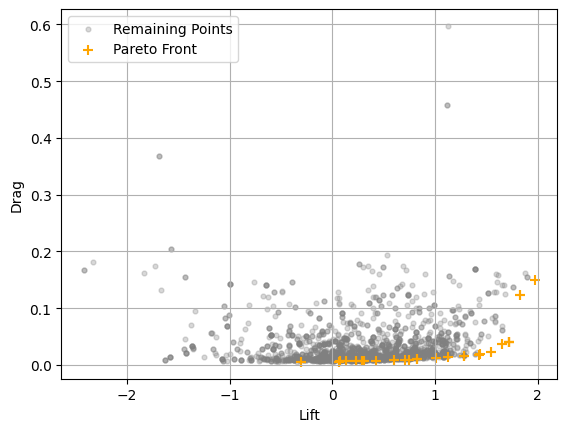

In [17]:
import os
import matplotlib.pyplot as plt

def load_population(folder="populations"):
    populations = {}
    
    for filename in os.listdir(folder):
        if filename.startswith("population_gen_") and filename.endswith(".txt"):
            gen_num = int(filename.split('_')[-1].split('.')[0])
            population = []
            
            with open(os.path.join(folder, filename), 'r') as file:
                for line in file:
                    if line.strip():
                        parts = line.strip().split('Fitness:')
                        individual_str = parts[0].strip()[1:-1]
                        fitness_str = parts[1].strip()[1:-1]
                        individual = list(map(float, individual_str.split(',')))
                        fitness = tuple(map(float, fitness_str.split(',')))
                        population.append((individual, fitness))
            
            populations[gen_num] = population
    
    return populations

def dominates(point1, point2):
    return (point1[0] >= point2[0] and point1[1] <= point2[1]) and (point1 != point2)

def pareto_front(points):
    pareto_points = []
    for i, point1 in enumerate(points):
        is_dominated = False
        for j, point2 in enumerate(points):
            if i != j and dominates(point2, point1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(point1)
    return pareto_points

# Load populations from the folder
populations = load_population()

lifts = []
drags = []
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            lifts.append(fit[0])
            drags.append(-fit[1])

# Combine the lists into a list of points
points = list(zip(lifts, drags))

# Find the Pareto front
pareto = pareto_front(points)

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]

# Plotting
plt.figure()
plt.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3, label="Remaining Points")
plt.scatter(pareto_l, pareto_d, color="orange", marker='+',s=50, label="Pareto Front")
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.legend()
plt.grid(True)
plt.show()


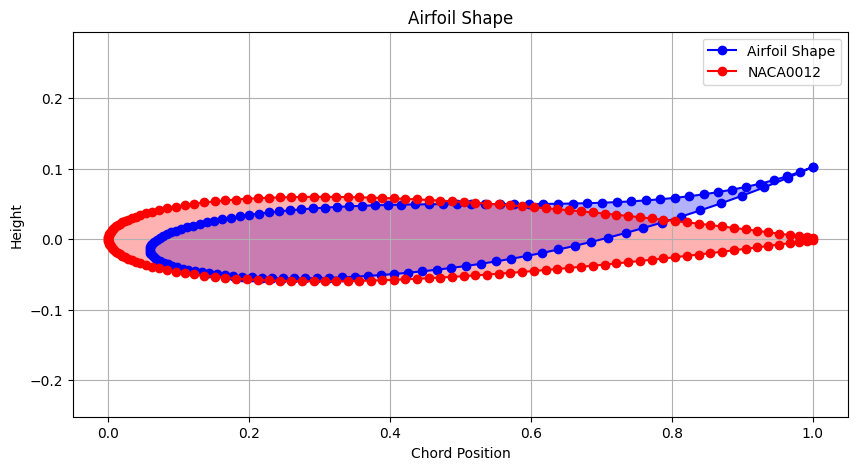

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift -0.3027132749557495, drag : 0.005472124554216862
direction -1.00, lift improvement -72.00%, drag improvement 63.46%


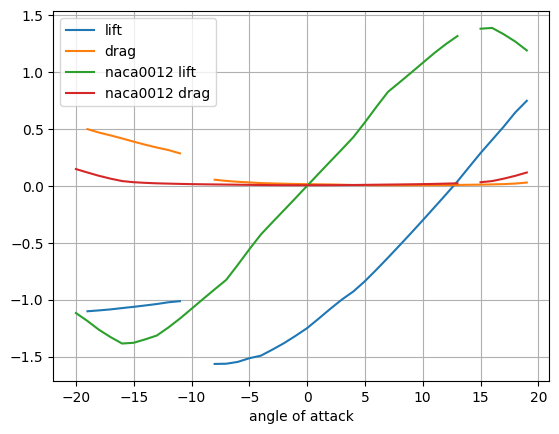

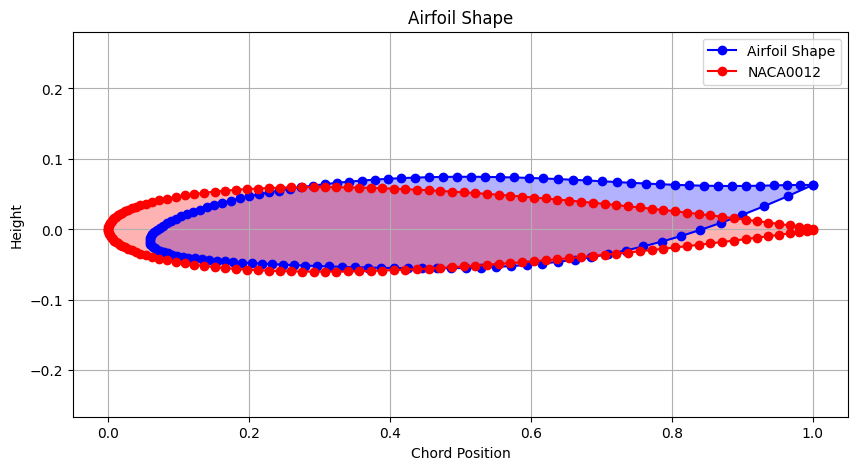

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.309882789850235, drag : 0.007433336693793535
direction 1.00, lift improvement -71.33%, drag improvement 50.37%


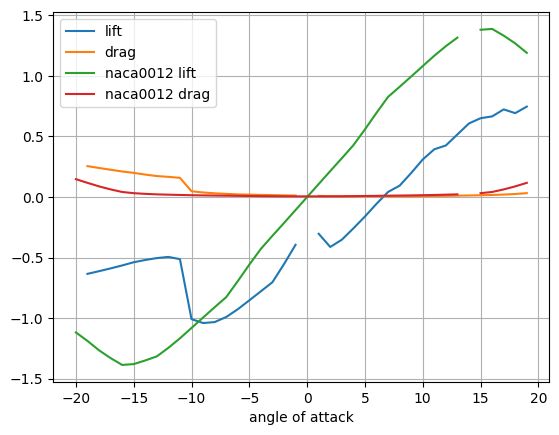

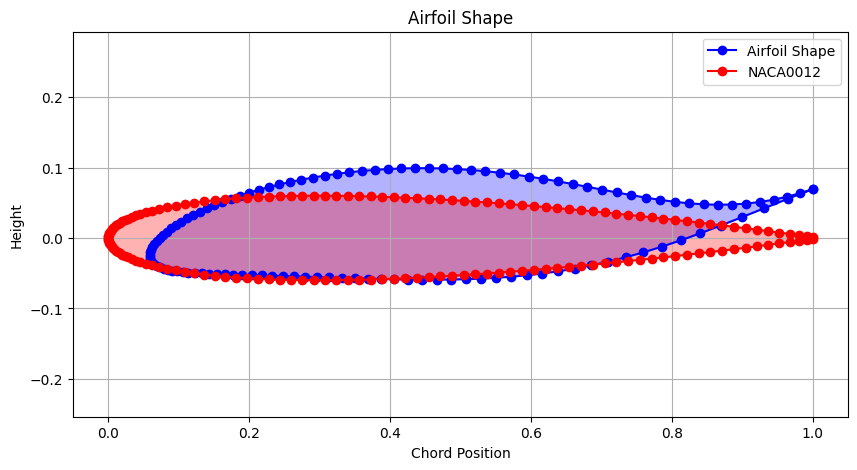

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.13867615163326263, drag : 0.006908486131578684
direction 1.00, lift improvement -87.17%, drag improvement 53.87%


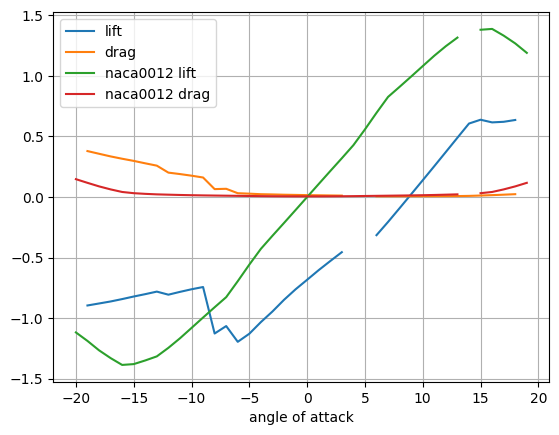

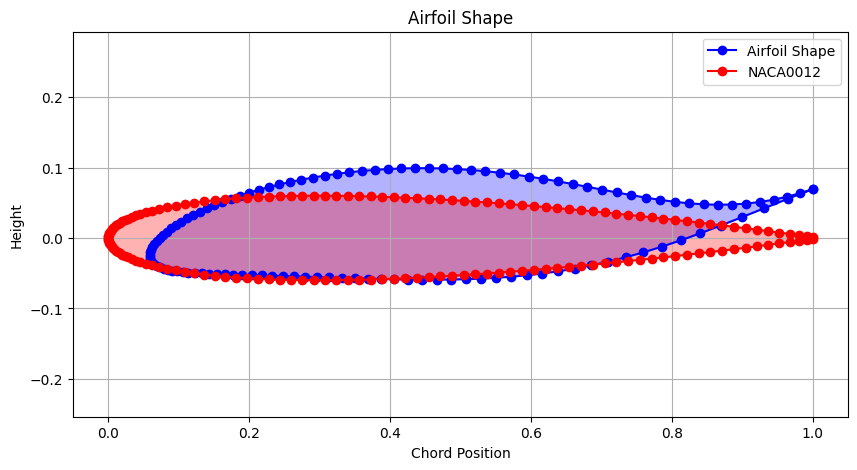

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.13867615163326263, drag : 0.006908486131578684
direction 1.00, lift improvement -87.17%, drag improvement 53.87%


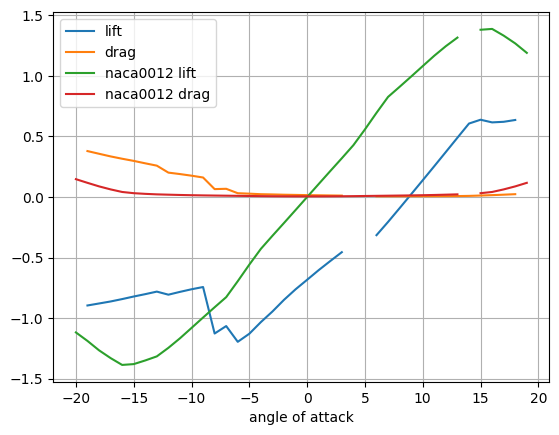

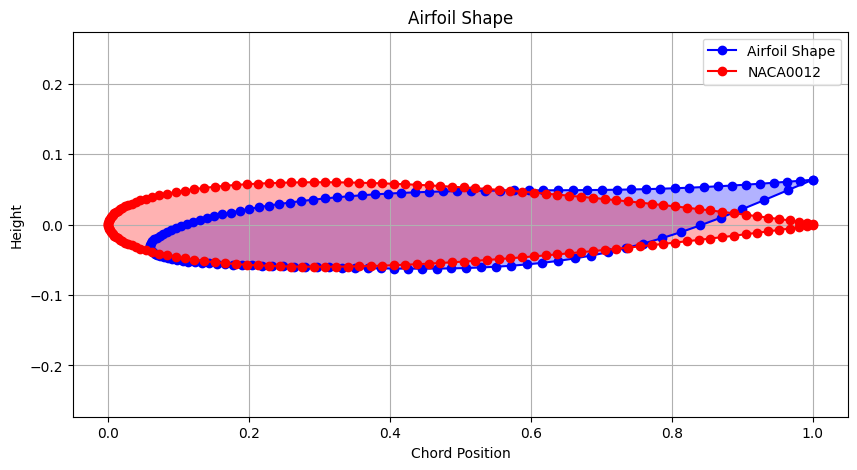

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.07282644510269165, drag : 0.006855865940451622
direction 1.00, lift improvement -93.26%, drag improvement 54.22%


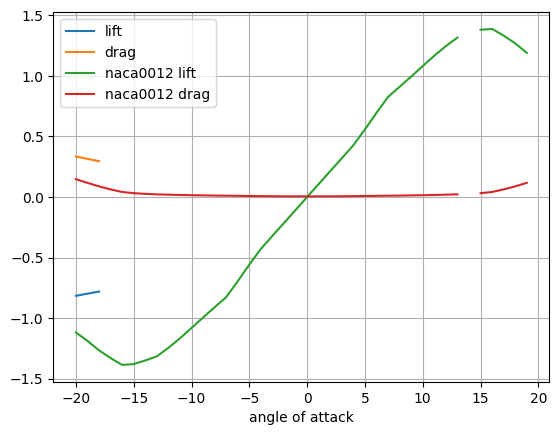

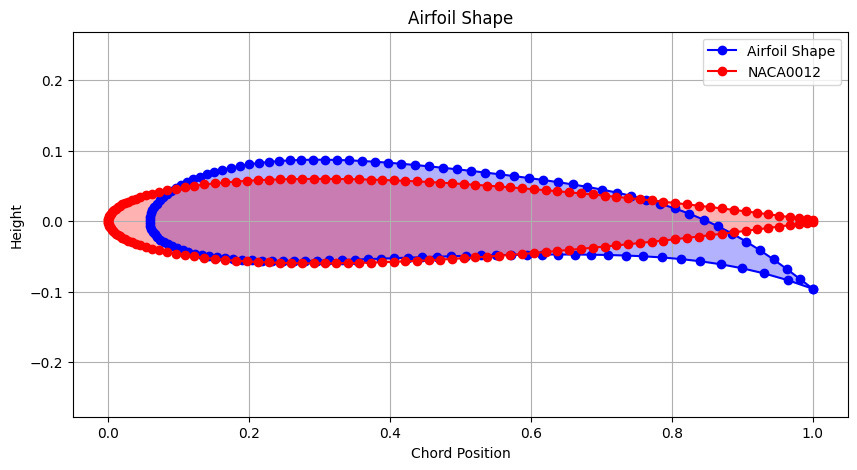

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.6532217264175415, drag : 0.037740204483270645
direction 1.00, lift improvement 52.94%, drag improvement -151.99%


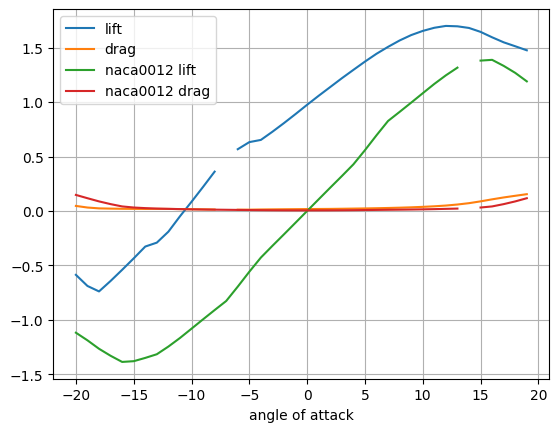

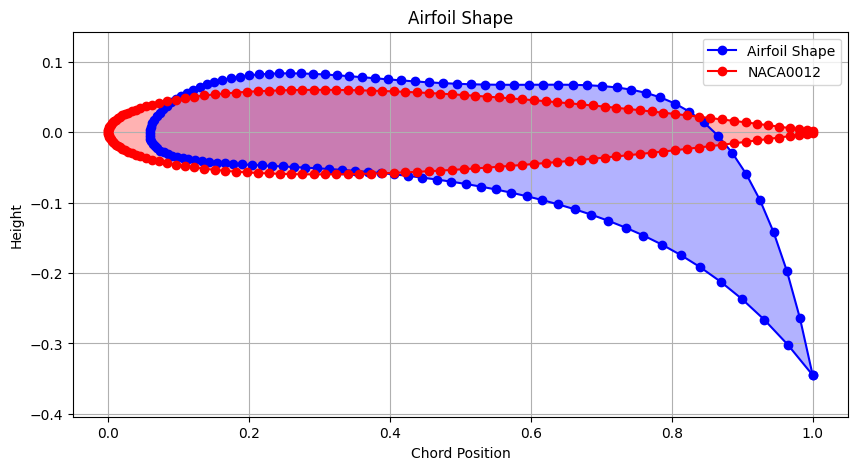

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.8281018733978271, drag : 0.12275419384241104
direction 1.00, lift improvement 69.12%, drag improvement -719.61%


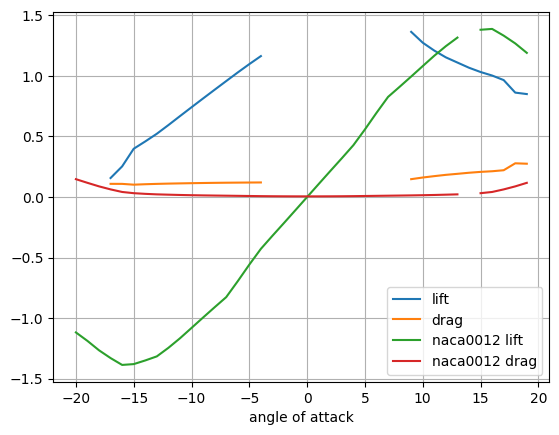

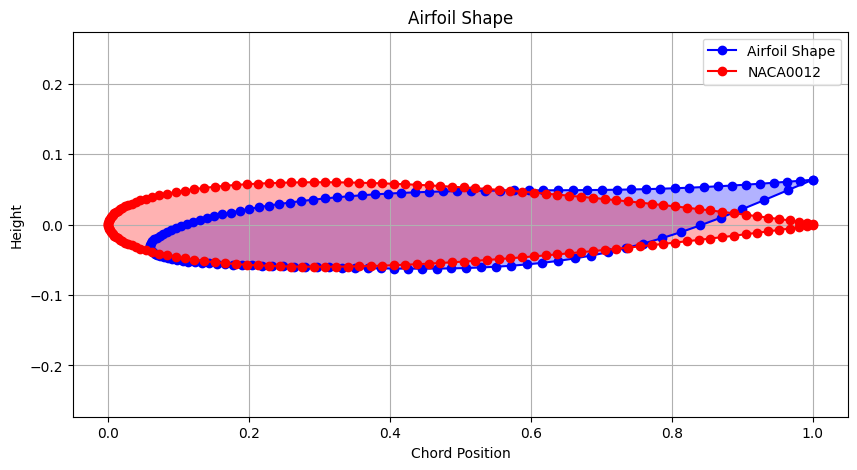

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.07282644510269165, drag : 0.006855865940451622
direction 1.00, lift improvement -93.26%, drag improvement 54.22%


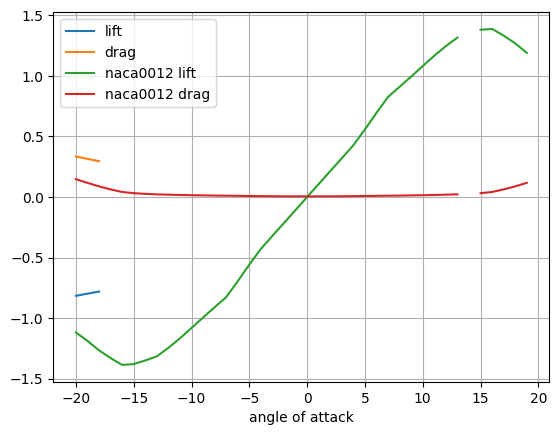

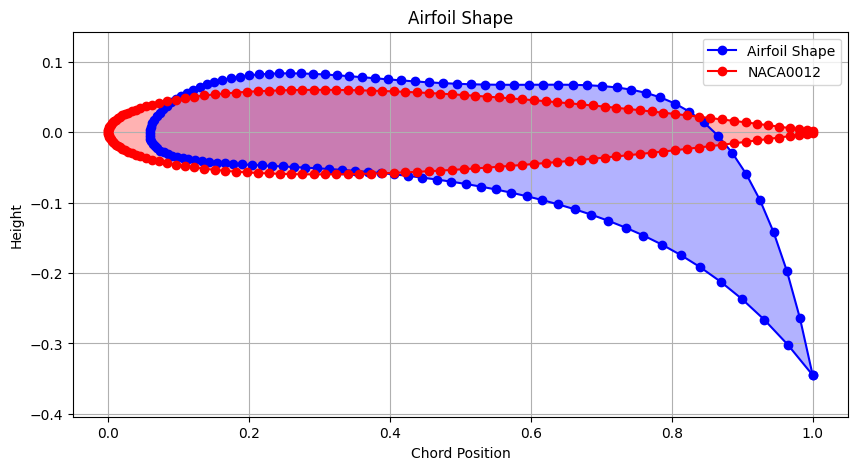

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.8281018733978271, drag : 0.12275419384241104
direction 1.00, lift improvement 69.12%, drag improvement -719.61%


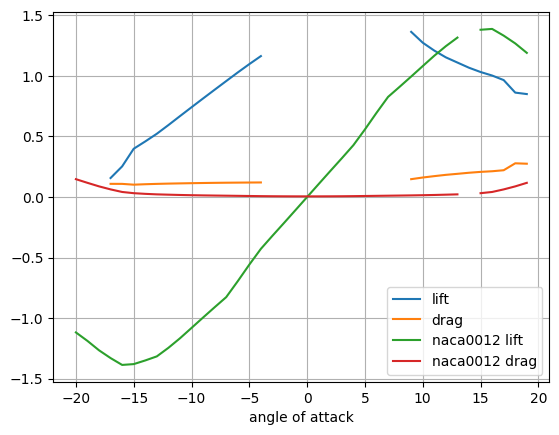

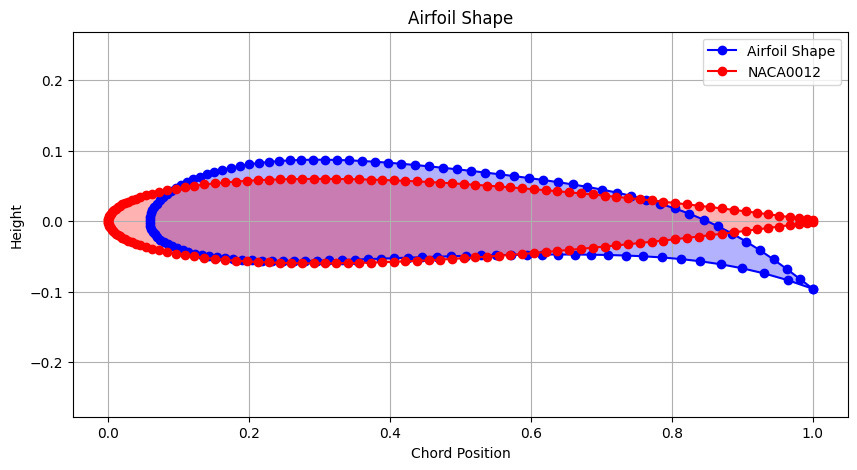

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.6532217264175415, drag : 0.037740204483270645
direction 1.00, lift improvement 52.94%, drag improvement -151.99%


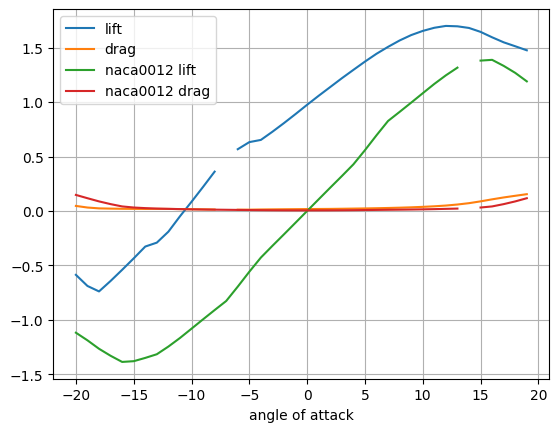

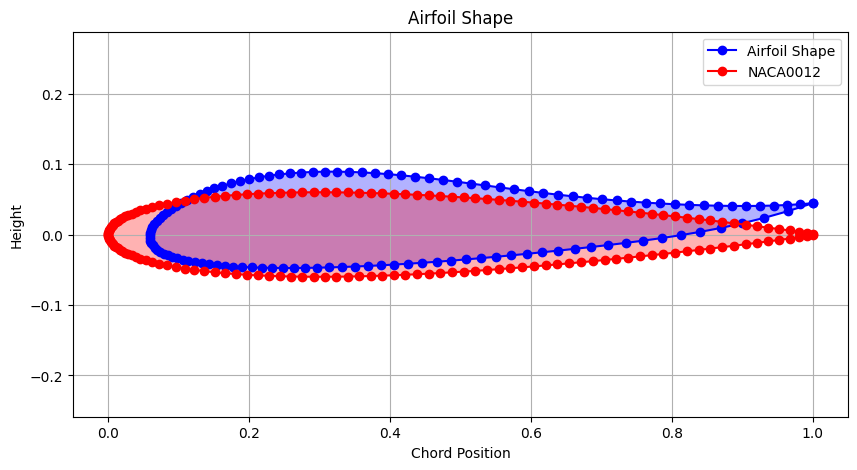

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.7467243075370789, drag : 0.009594985283911228
direction 1.00, lift improvement -30.92%, drag improvement 35.94%


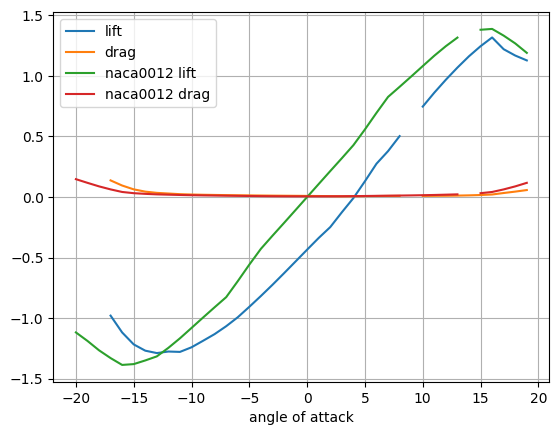

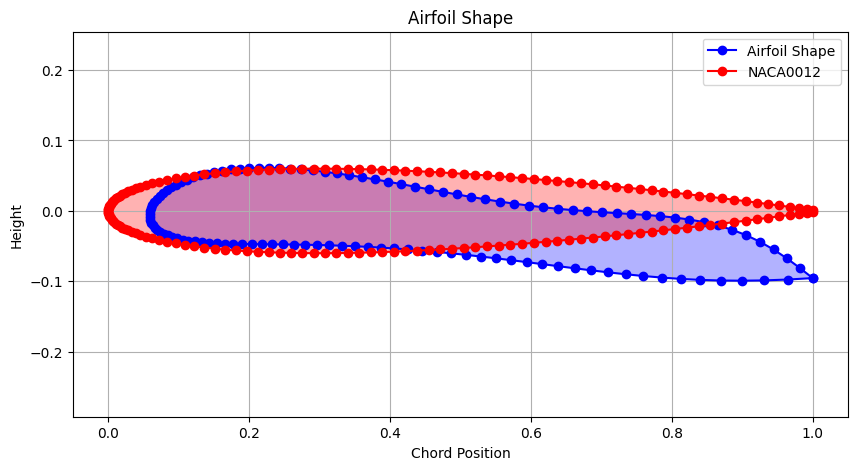

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5410256385803223, drag : 0.022965995594859123
direction 1.00, lift improvement 42.56%, drag improvement -53.34%


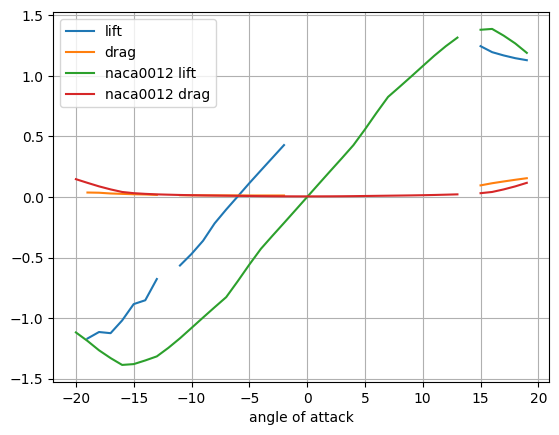

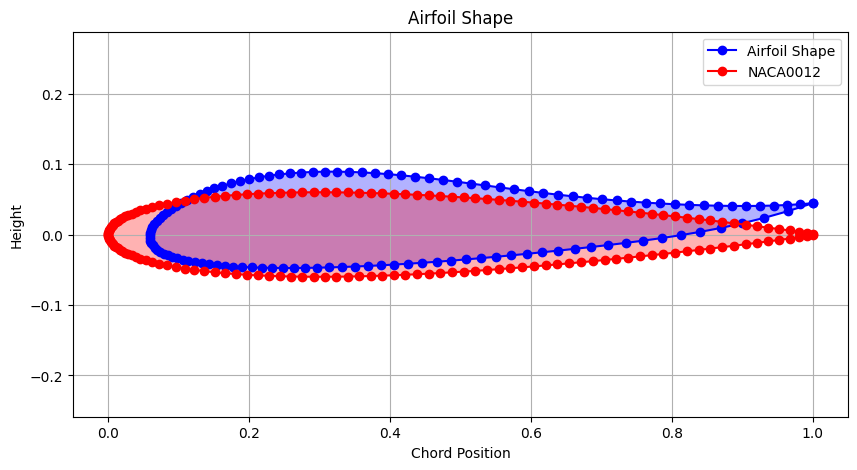

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.7467243075370789, drag : 0.009594985283911228
direction 1.00, lift improvement -30.92%, drag improvement 35.94%


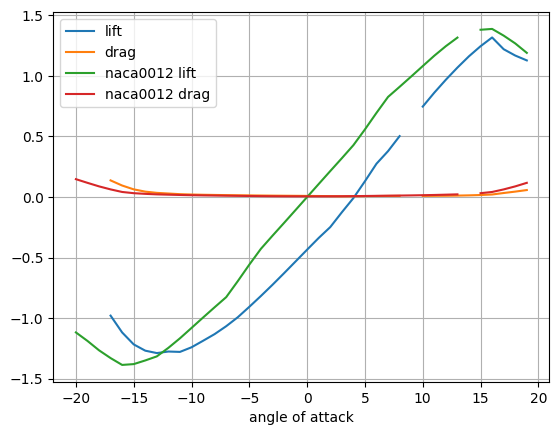

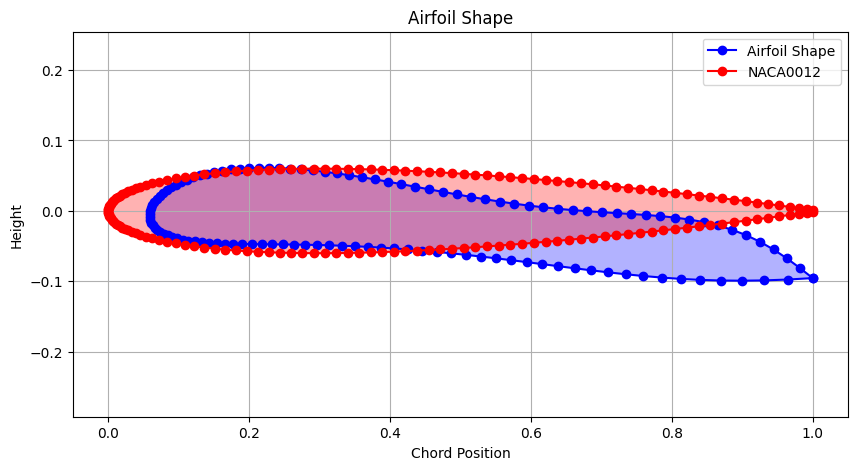

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.5410256385803223, drag : 0.022965995594859123
direction 1.00, lift improvement 42.56%, drag improvement -53.34%


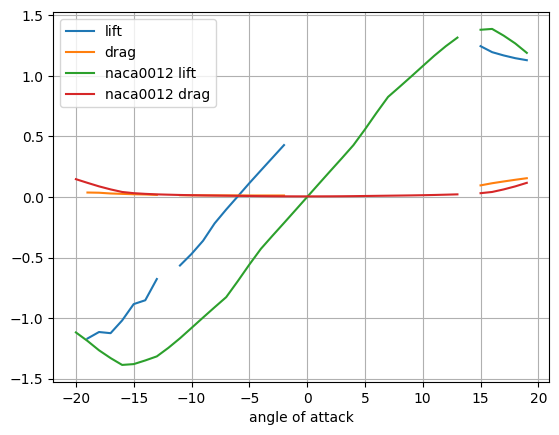

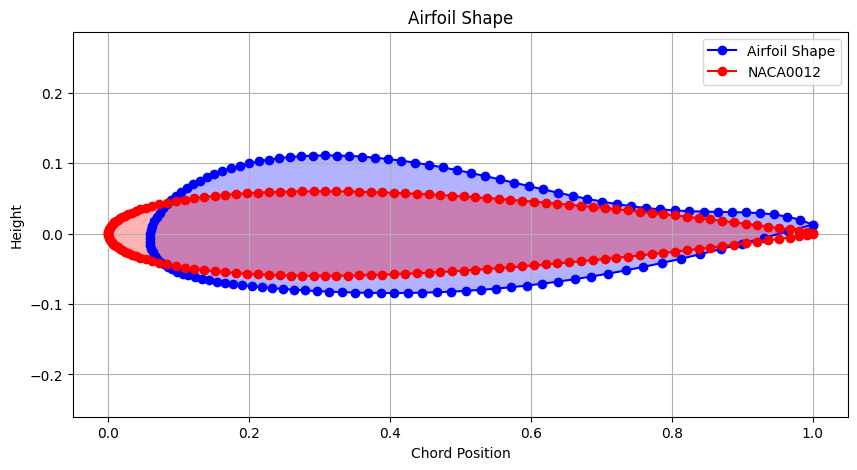

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.8214555382728577, drag : 0.010593733750283718
direction 1.00, lift improvement -24.01%, drag improvement 29.27%


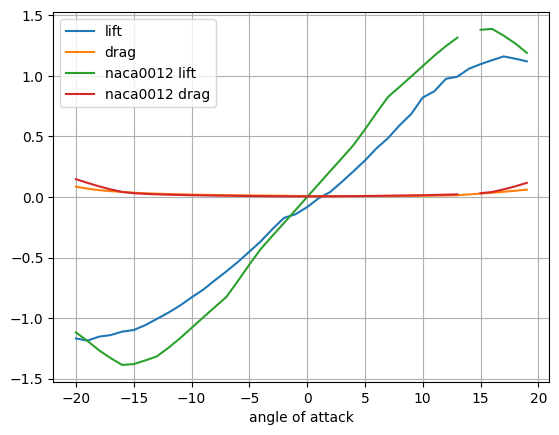

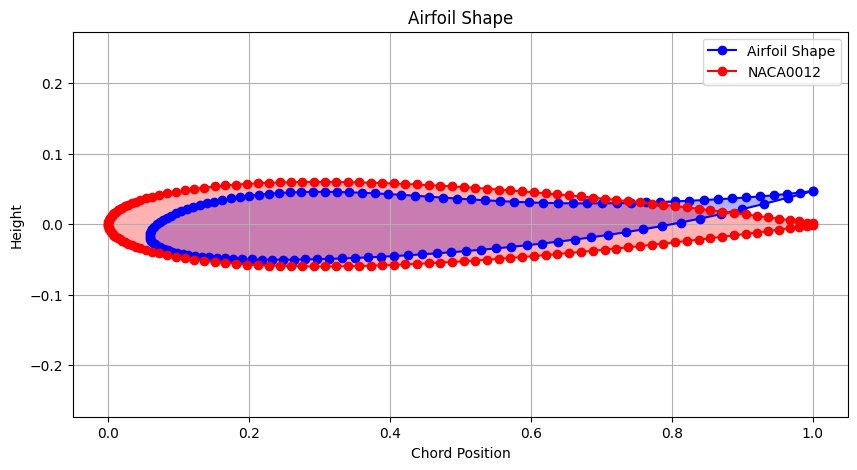

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.42439380288124084, drag : 0.007904201745986938
direction 1.00, lift improvement -60.74%, drag improvement 47.22%


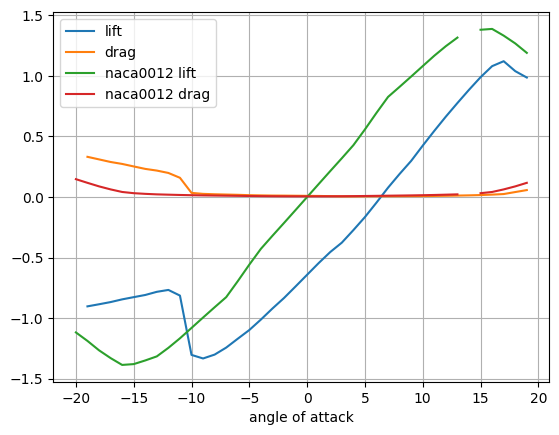

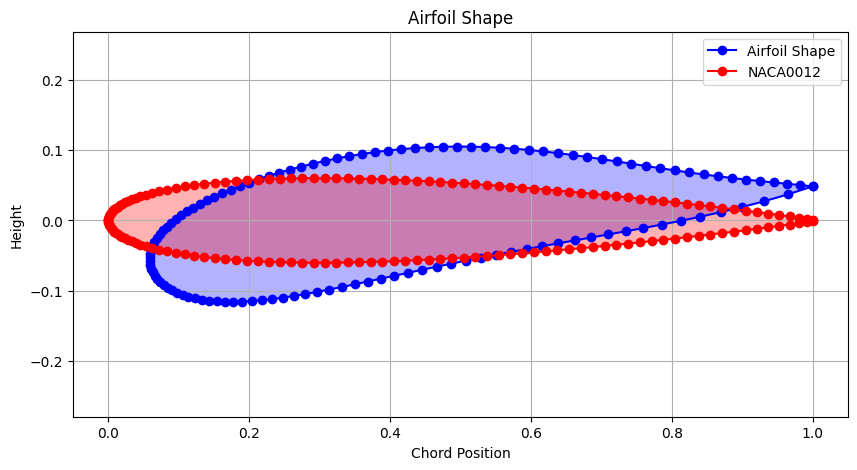

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.6046760082244873, drag : 0.008175695315003395
direction 1.00, lift improvement -44.06%, drag improvement 45.41%


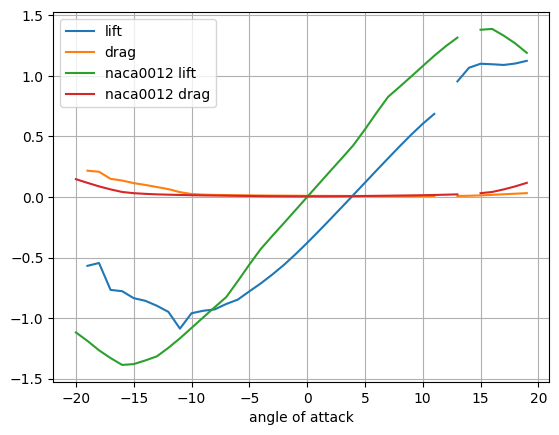

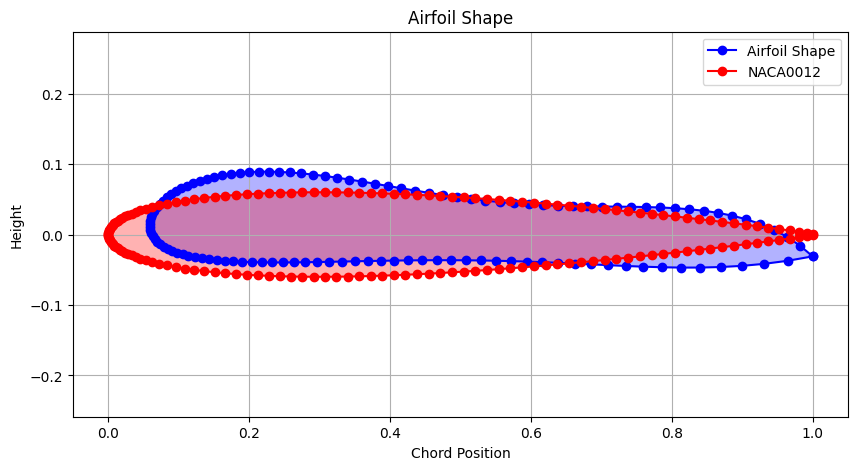

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.4307929277420044, drag : 0.01785680465400219
direction 1.00, lift improvement 32.37%, drag improvement -19.23%


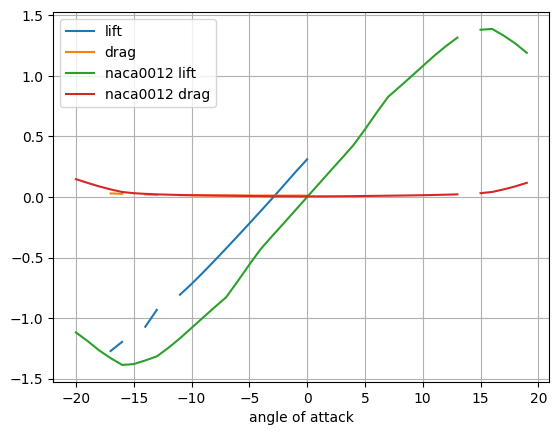

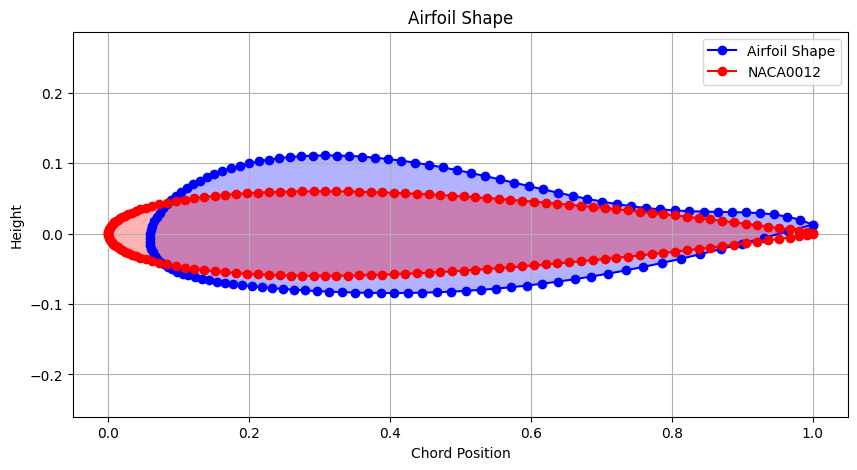

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.8214555382728577, drag : 0.010593733750283718
direction 1.00, lift improvement -24.01%, drag improvement 29.27%


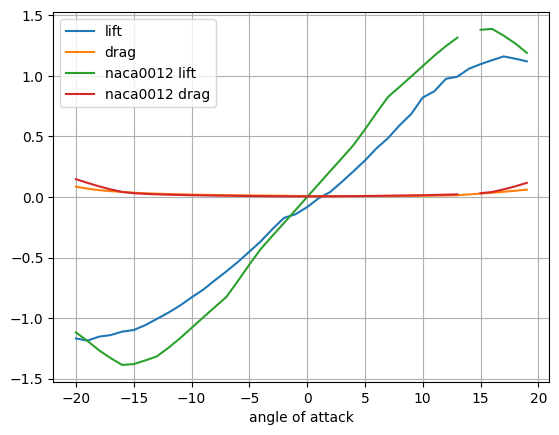

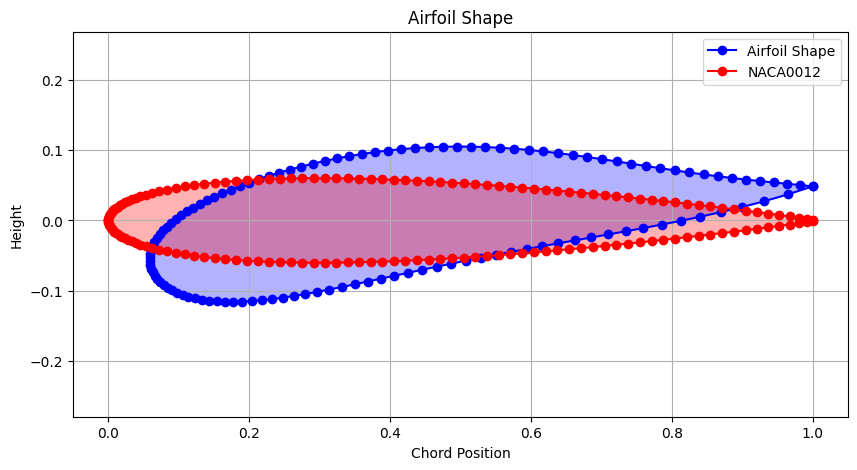

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.6046760082244873, drag : 0.008175695315003395
direction 1.00, lift improvement -44.06%, drag improvement 45.41%


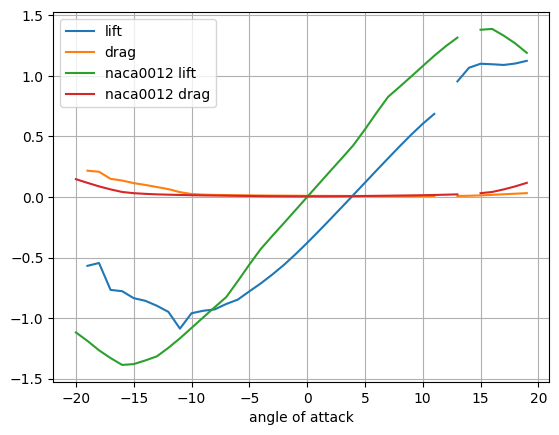

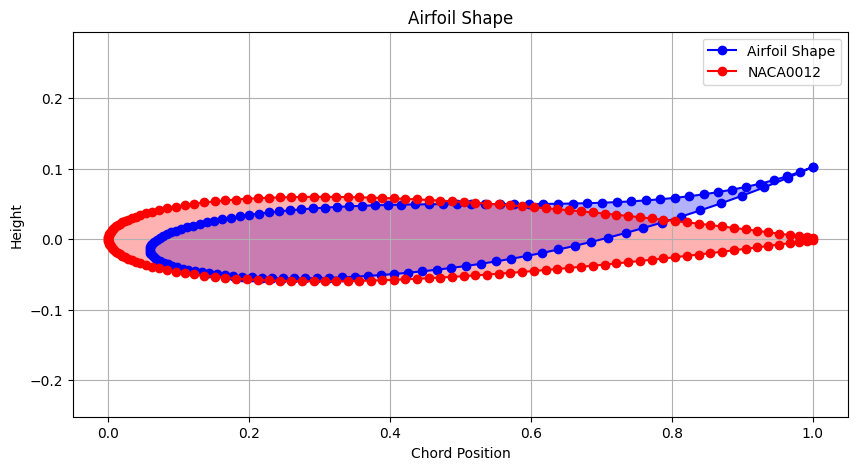

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift -0.3027132749557495, drag : 0.005472124554216862
direction -1.00, lift improvement -72.00%, drag improvement 63.46%


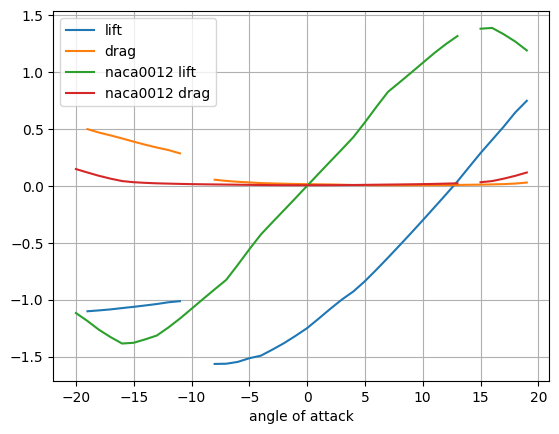

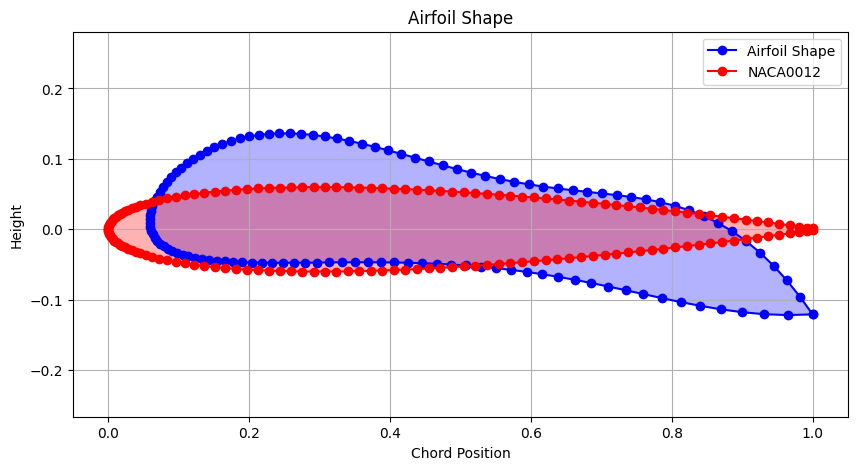

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.716968297958374, drag : 0.04141313210129738
direction 1.00, lift improvement 58.84%, drag improvement -176.51%


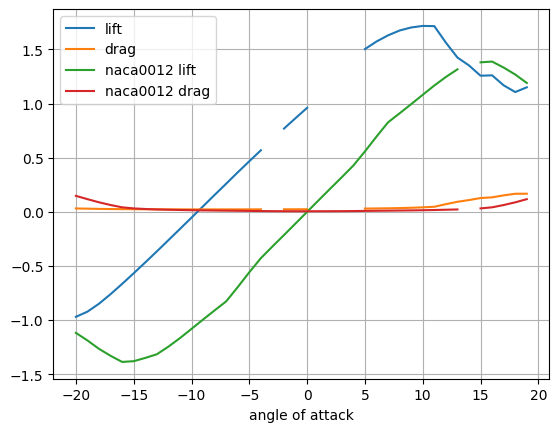

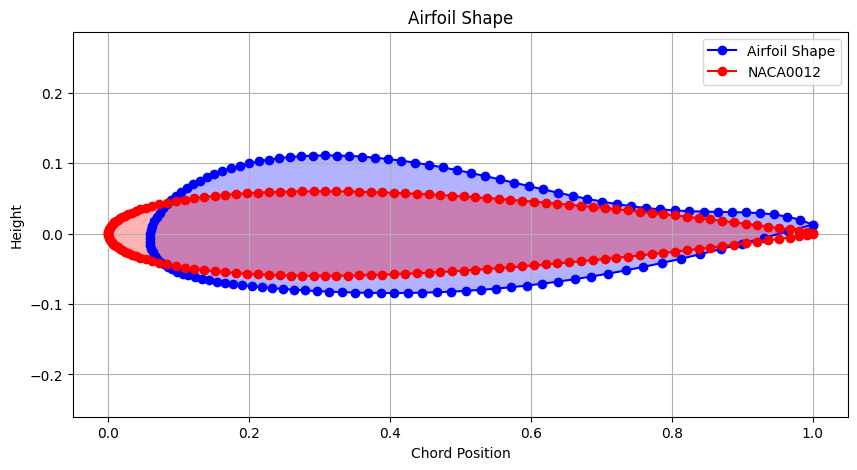

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.8214555382728577, drag : 0.010593733750283718
direction 1.00, lift improvement -24.01%, drag improvement 29.27%


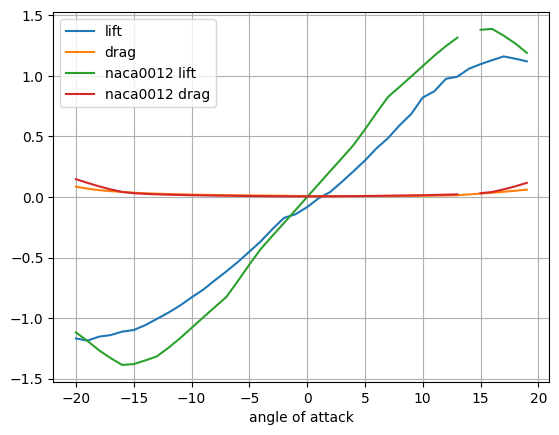

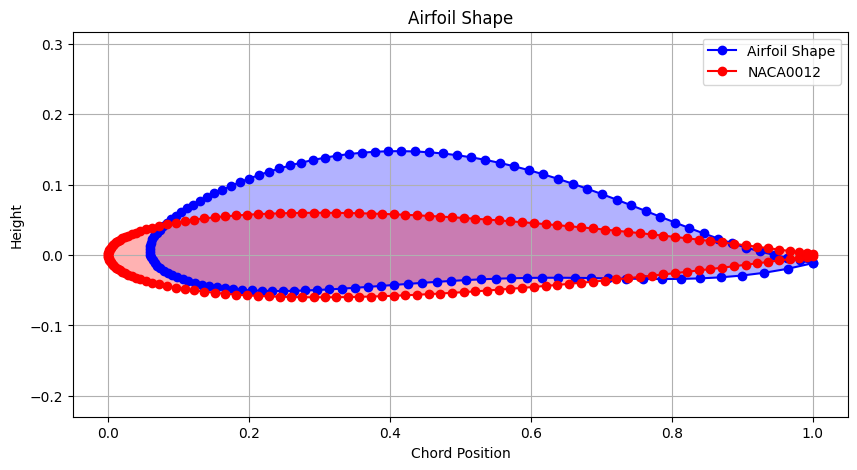

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.437383770942688, drag : 0.020015044137835503
direction 1.00, lift improvement 32.98%, drag improvement -33.64%


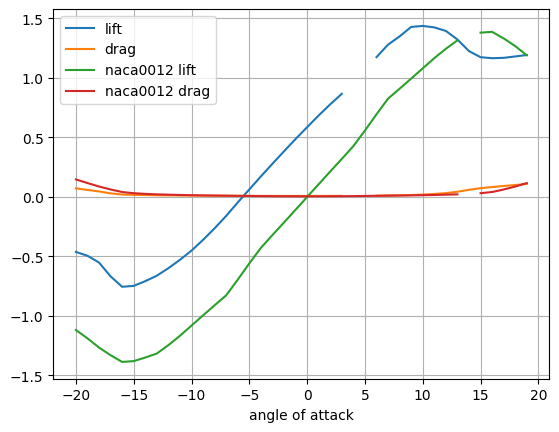

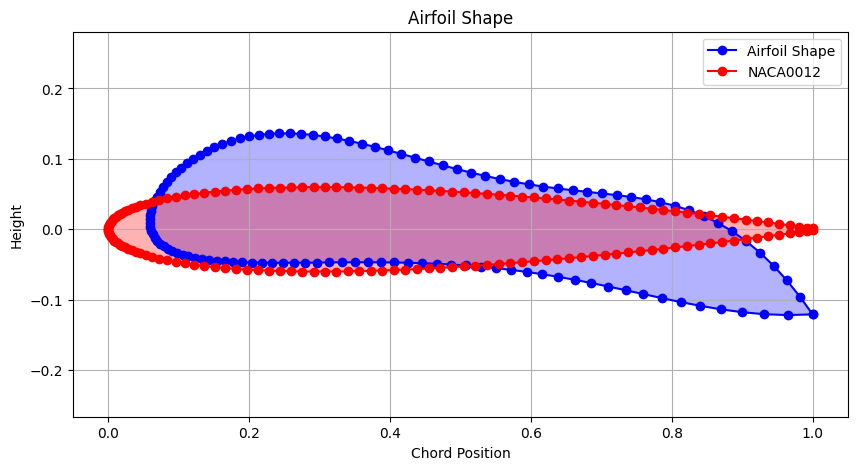

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.716968297958374, drag : 0.04141313210129738
direction 1.00, lift improvement 58.84%, drag improvement -176.51%


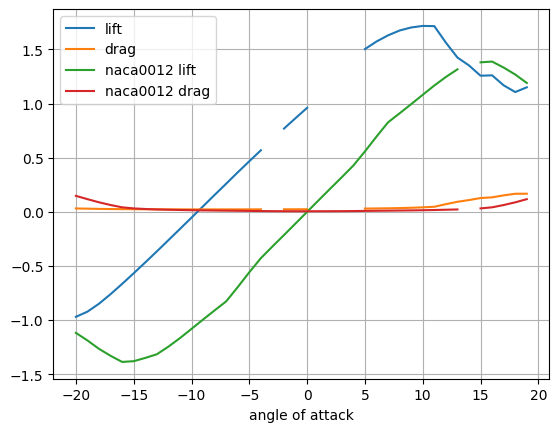

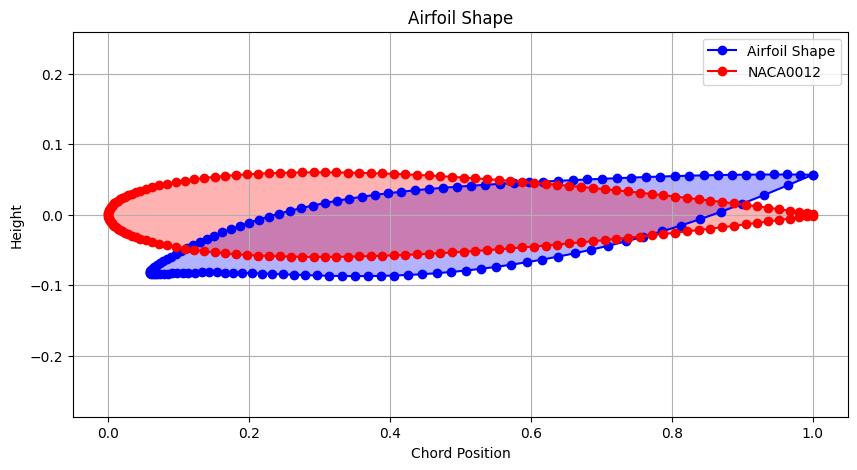

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.07062230259180069, drag : 0.006032183766365051
direction 1.00, lift improvement -93.47%, drag improvement 59.72%


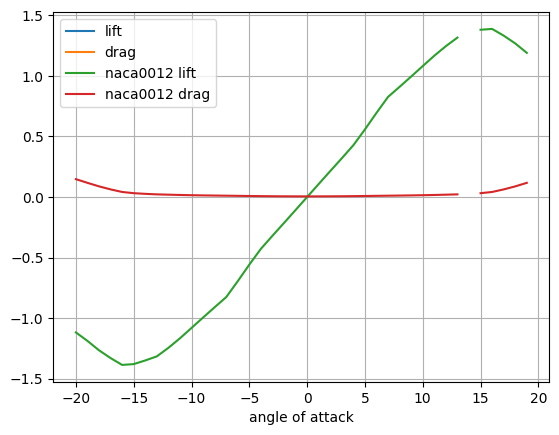

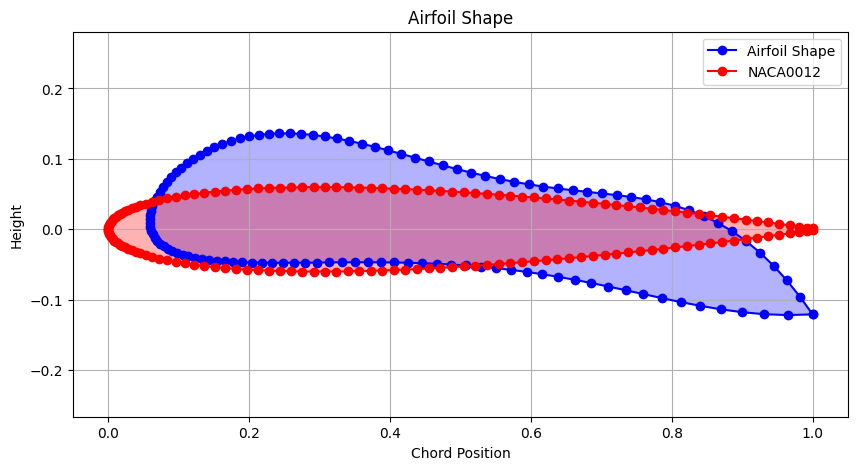

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.716968297958374, drag : 0.04141313210129738
direction 1.00, lift improvement 58.84%, drag improvement -176.51%


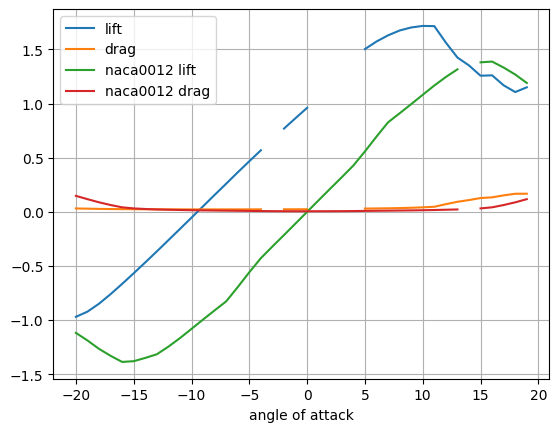

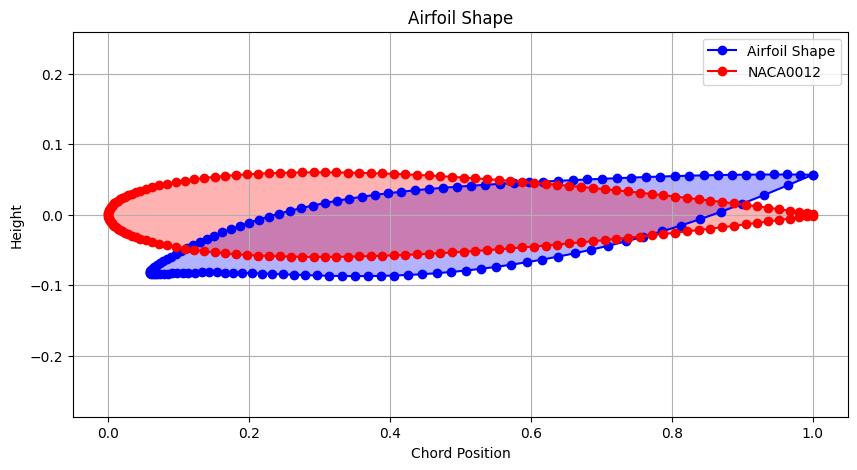

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.07062230259180069, drag : 0.006032183766365051
direction 1.00, lift improvement -93.47%, drag improvement 59.72%


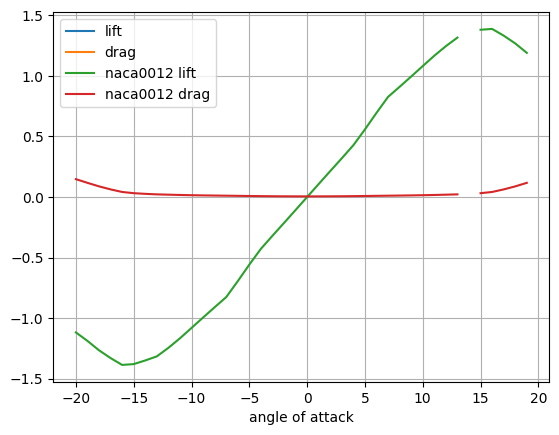

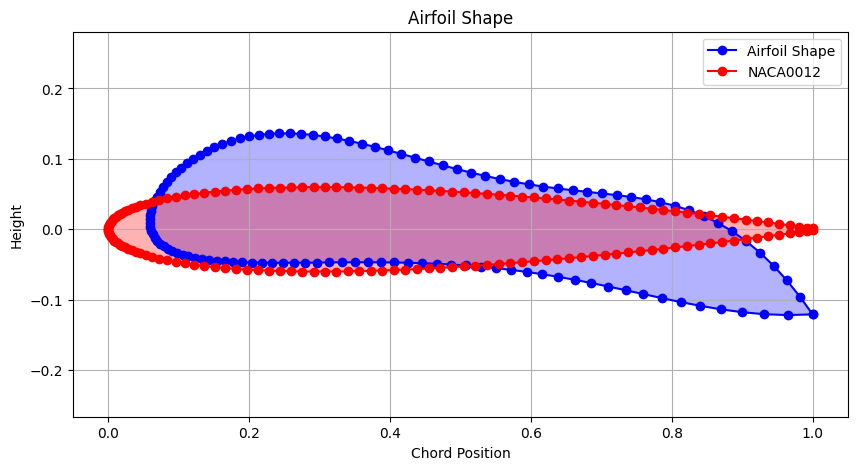

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.716968297958374, drag : 0.04141313210129738
direction 1.00, lift improvement 58.84%, drag improvement -176.51%


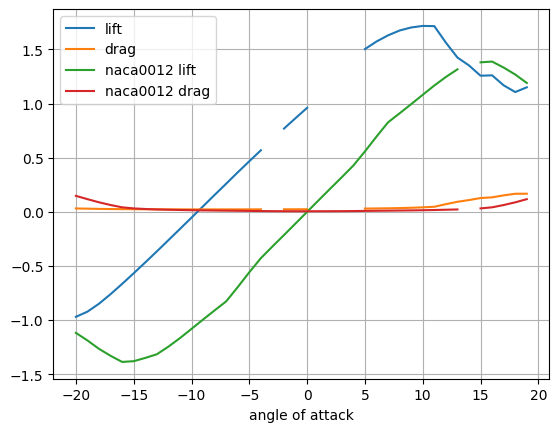

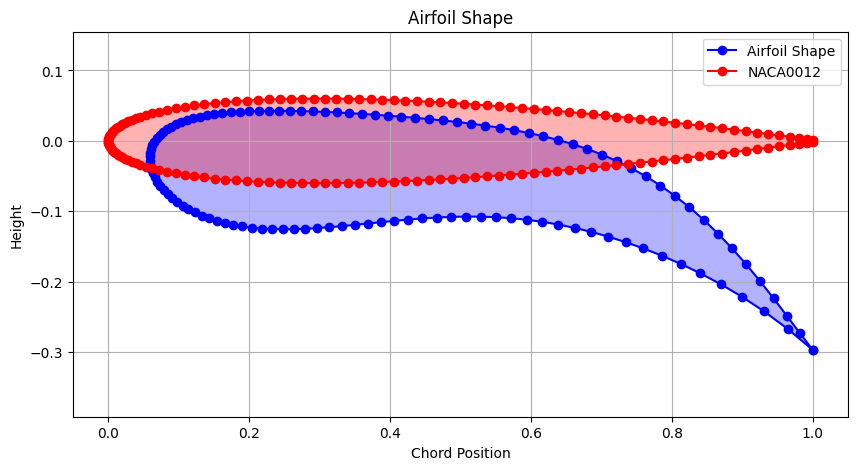

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.9712570905685425, drag : 0.15033598244190216
direction 1.00, lift improvement 82.37%, drag improvement -903.77%


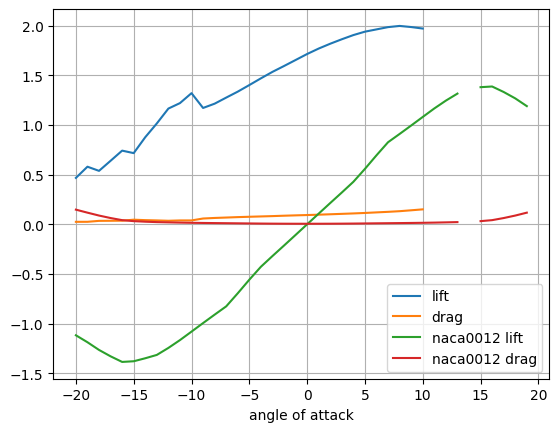

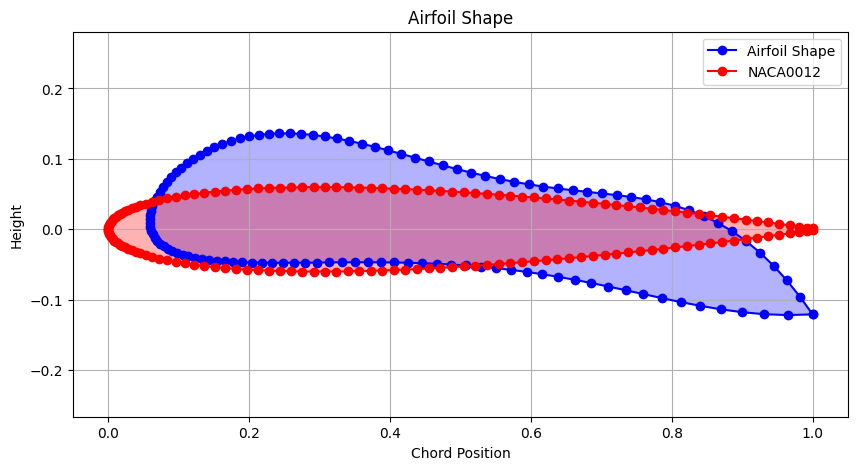

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.716968297958374, drag : 0.04141313210129738
direction 1.00, lift improvement 58.84%, drag improvement -176.51%


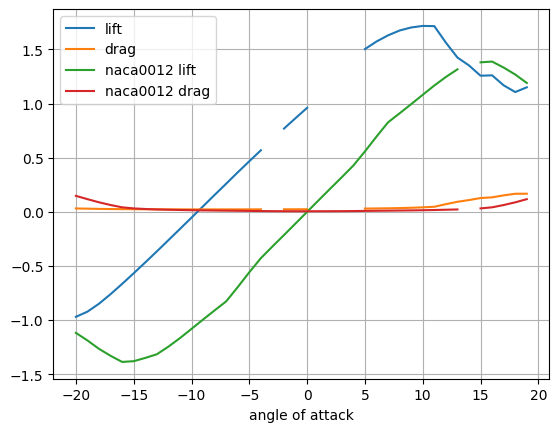

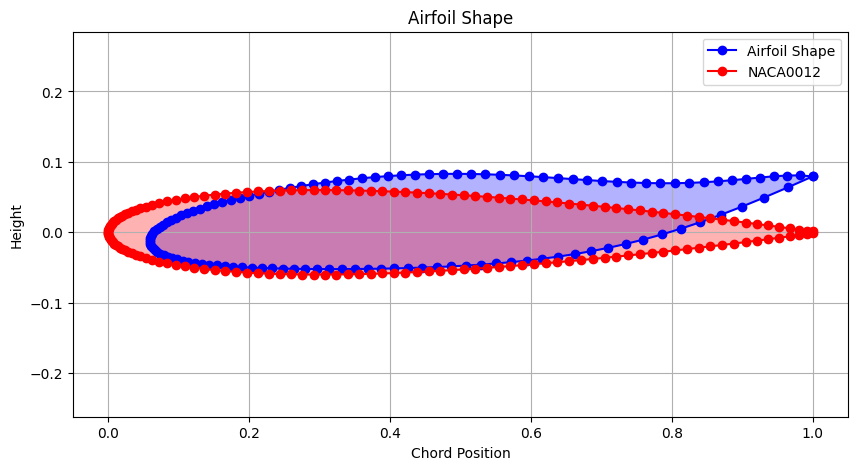

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.22774365544319153, drag : 0.006988969165831804
direction 1.00, lift improvement -78.93%, drag improvement 53.34%


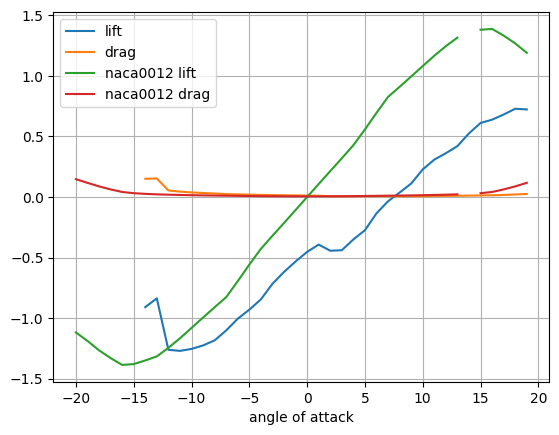

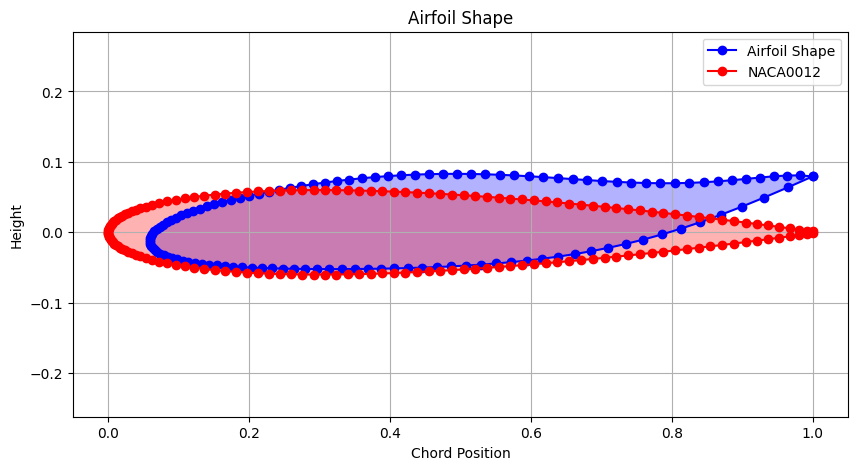

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.22774365544319153, drag : 0.006988969165831804
direction 1.00, lift improvement -78.93%, drag improvement 53.34%


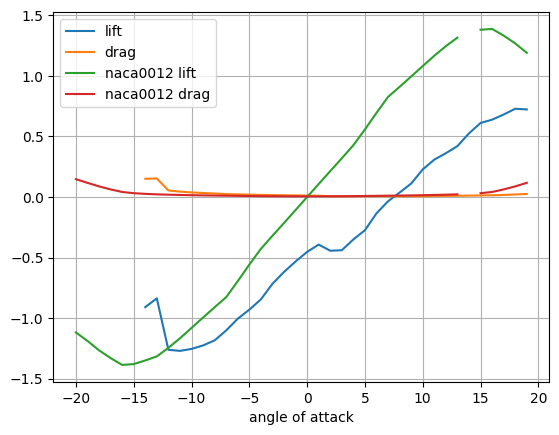

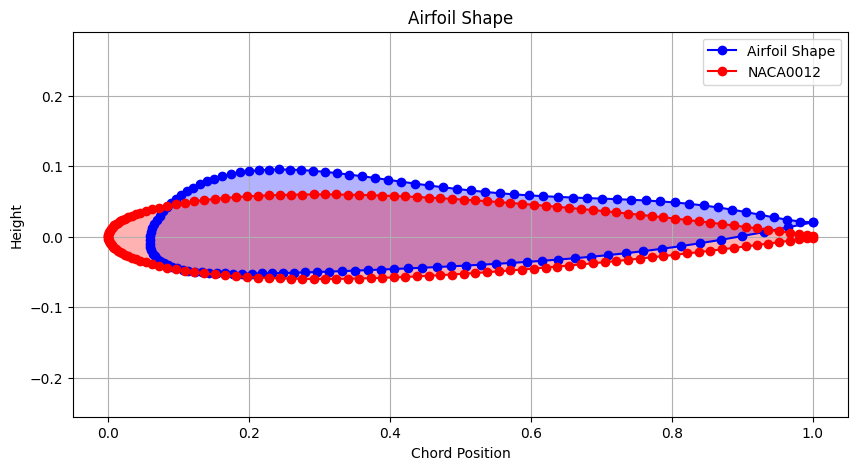

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.0073602199554443, drag : 0.011783952824771404
direction 1.00, lift improvement -6.81%, drag improvement 21.32%


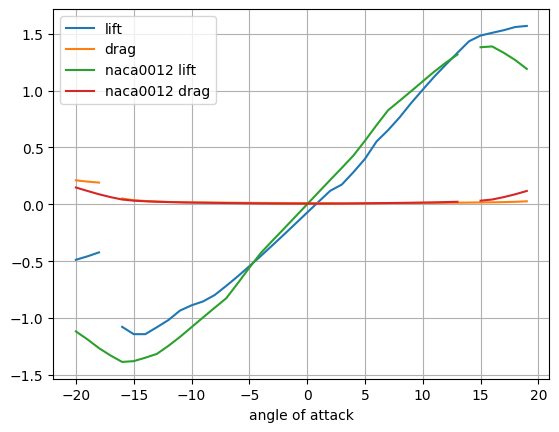

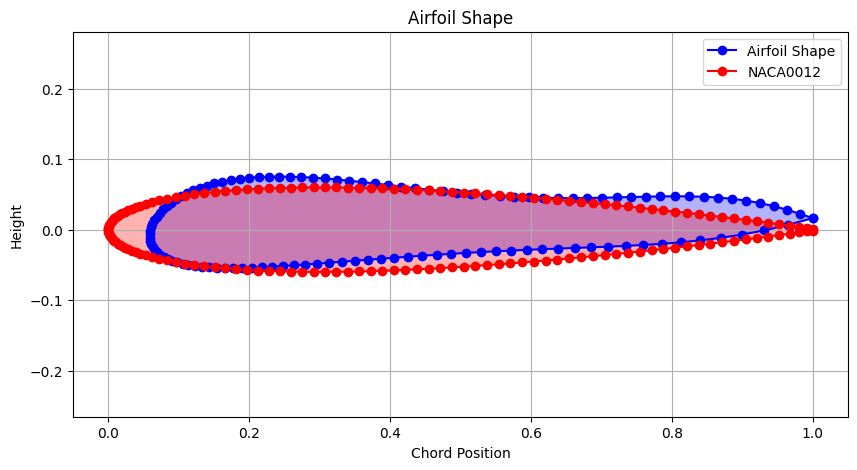

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.128755807876587, drag : 0.013342284597456455
direction 1.00, lift improvement 4.42%, drag improvement 10.92%


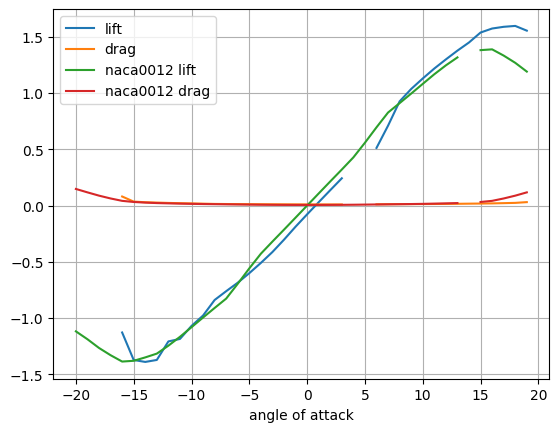

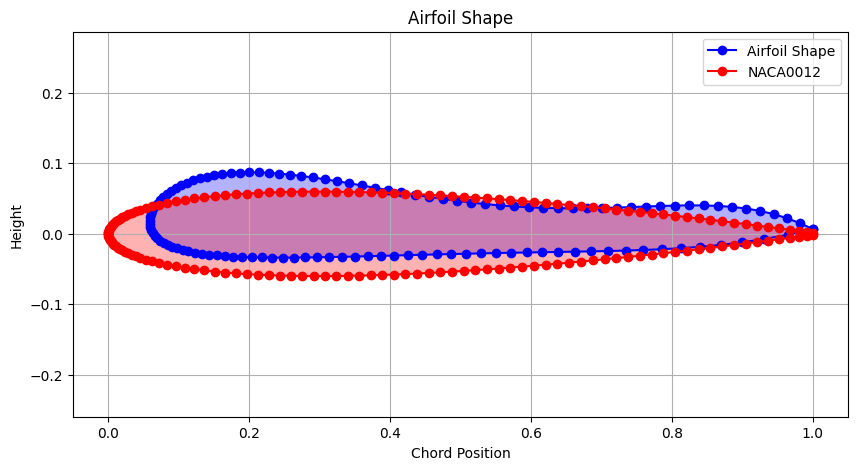

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.282127022743225, drag : 0.015109662897884846
direction 1.00, lift improvement 18.61%, drag improvement -0.89%


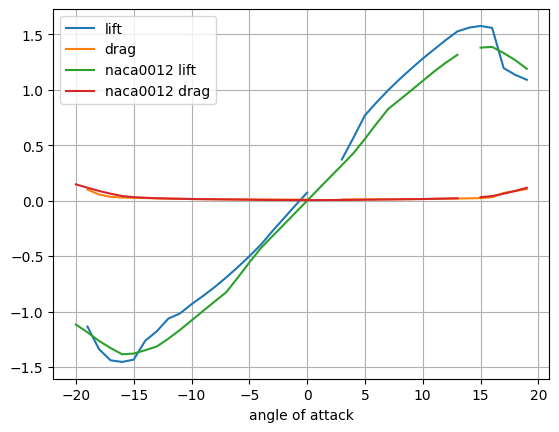

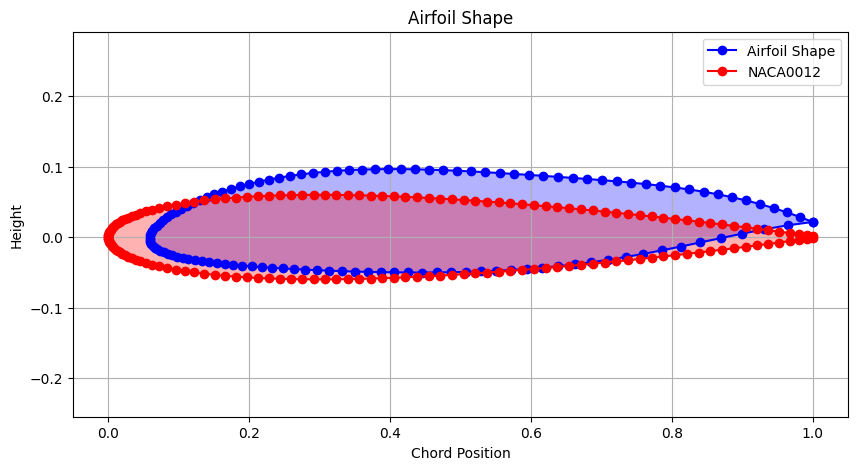

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.7069457173347473, drag : 0.009452838450670242
direction 1.00, lift improvement -34.60%, drag improvement 36.88%


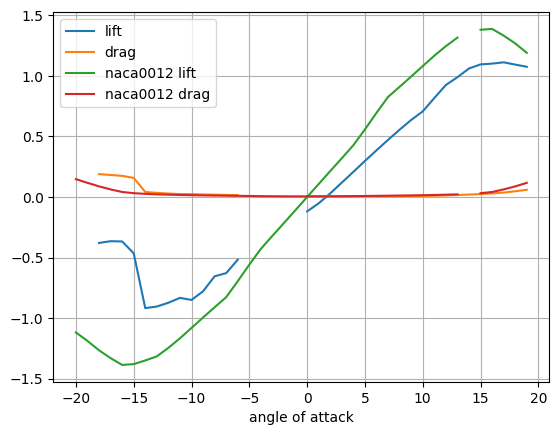

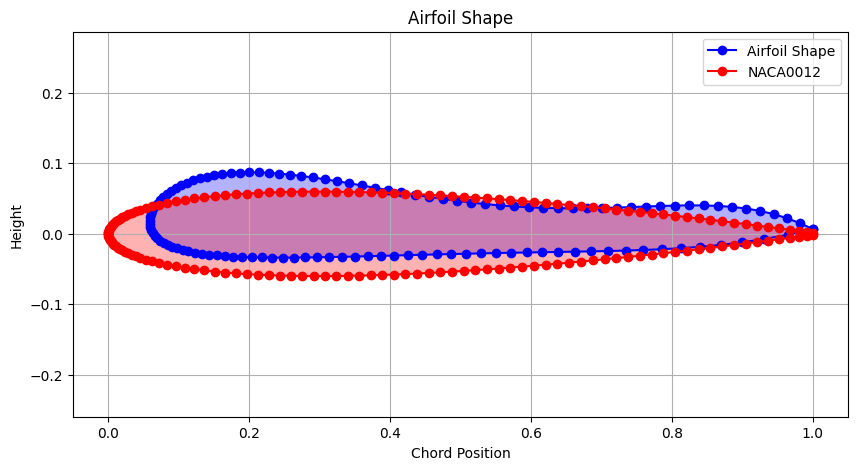

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.282127022743225, drag : 0.015109662897884846
direction 1.00, lift improvement 18.61%, drag improvement -0.89%


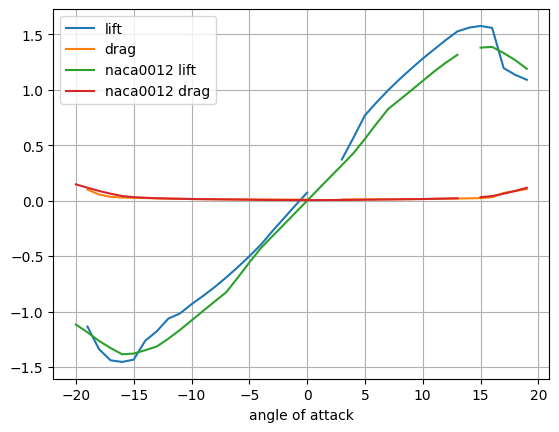

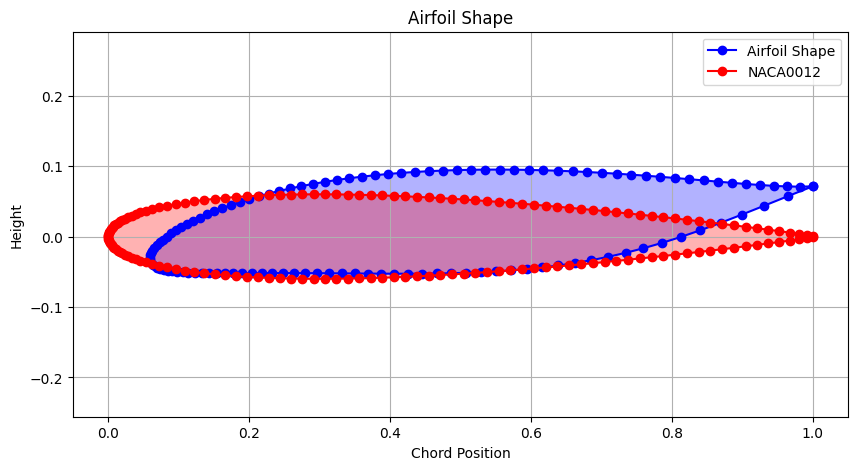

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.2873845100402832, drag : 0.0070272223092615604
direction 1.00, lift improvement -73.41%, drag improvement 53.08%


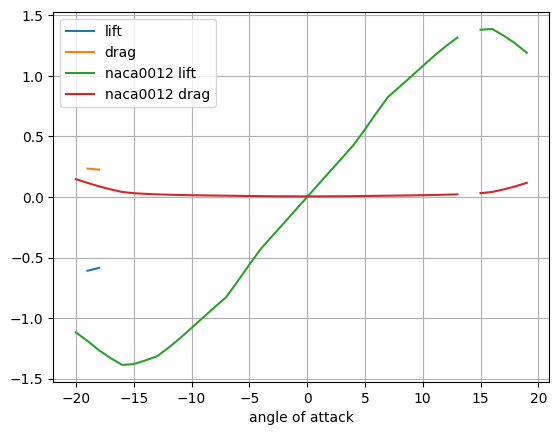

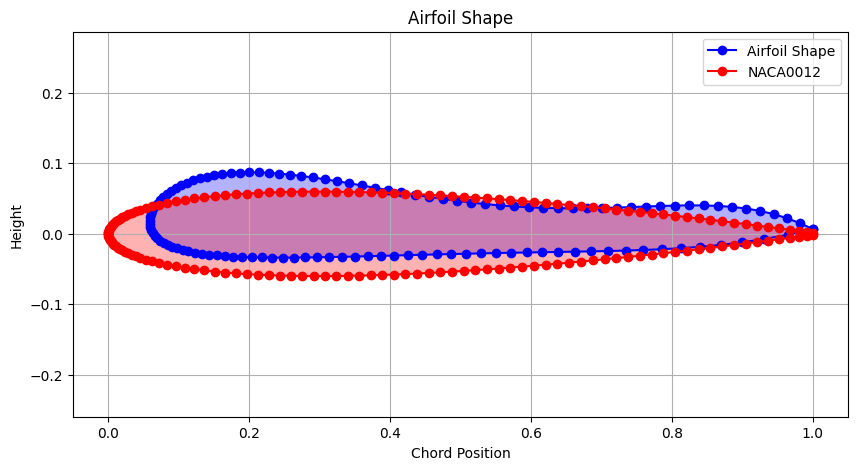

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 1.282127022743225, drag : 0.015109662897884846
direction 1.00, lift improvement 18.61%, drag improvement -0.89%


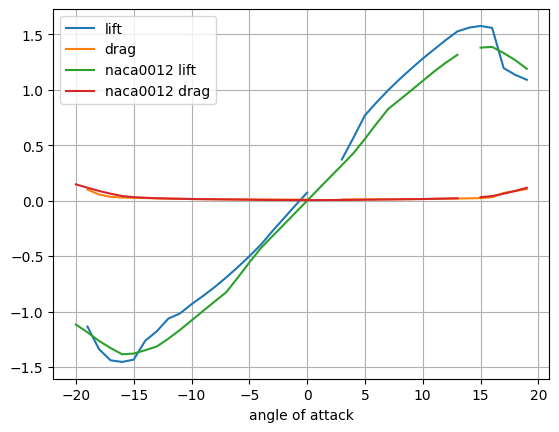

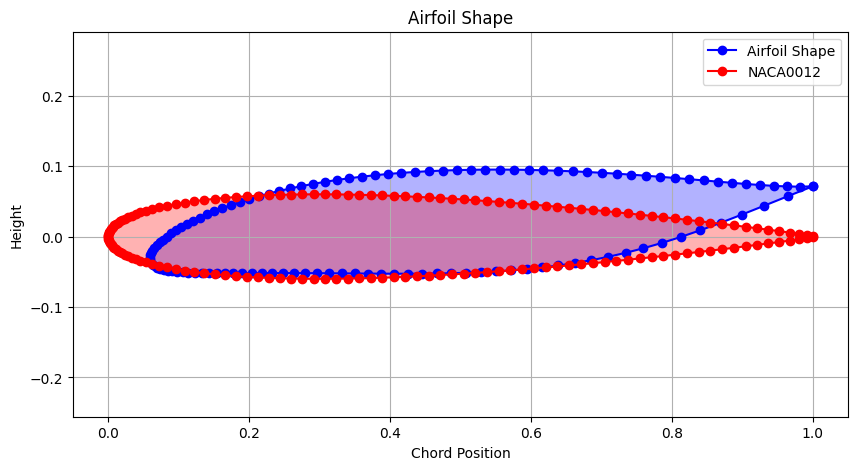

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.2873845100402832, drag : 0.0070272223092615604
direction 1.00, lift improvement -73.41%, drag improvement 53.08%


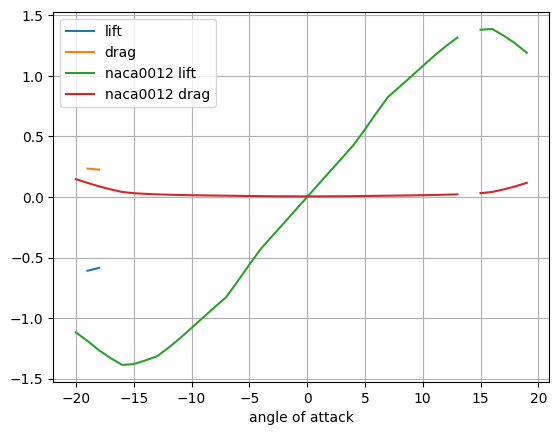

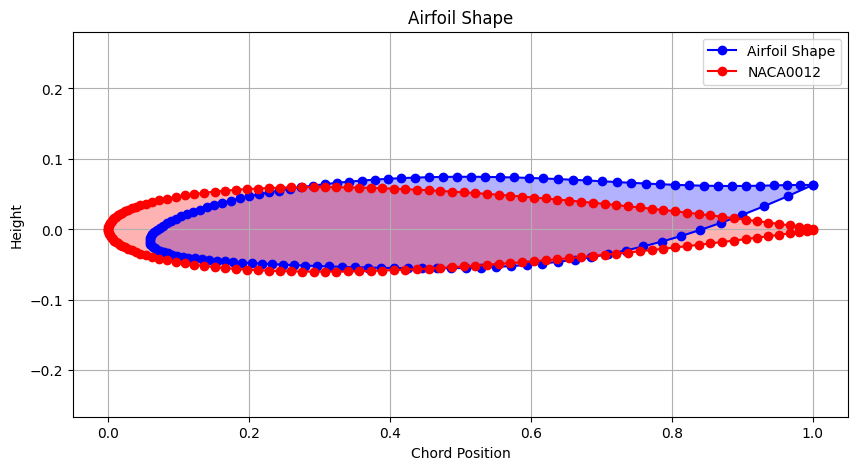

naca0012 fitness : lift 1.0809400081634521, drag : 0.014977115206420422
best indiv fitness : lift 0.309882789850235, drag : 0.007433336693793535
direction 1.00, lift improvement -71.33%, drag improvement 50.37%


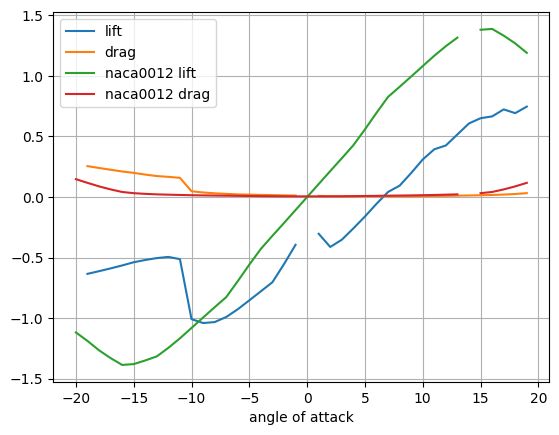

In [25]:
naca_a , naca_cl, naca_cd = naca_eval()
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                plot_foil(best)
                a, cl, cd = evaluate_airfoil_angle_attacks(ind)
                plt.figure()
                plt.plot(a, cl, label="lift")
                plt.plot(a, cd, label="drag")
                plt.plot(naca_a, naca_cl, label="naca0012 lift")
                plt.plot(naca_a, naca_cd, label="naca0012 drag")
                plt.legend()
                plt.xlabel("angle of attack")
                plt.grid(True)
                naca0012_fit = np.array(fitness(naca0012))
                print(f"naca0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
                print(f"best indiv fitness : lift {fit[0]}, drag : {-fit[1]}")

                direction = fit[0] / abs(fit[0])
                lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
                drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100

                print(f"direction {direction:.2f}, lift improvement {lift_improvement:.2f}%, drag improvement {drag_improvement:.2f}%")

                
